In [1]:
from langchain.schema import Document
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings


embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]

db = Chroma.from_documents(docs, embedding_function)

C:\Users\Acer\AppData\Local\Temp\ipykernel_25204\2809430918.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
retriever = db.as_retriever(search_type="mmr", search_kwargs = {"k": 3})

In [3]:
retriever.invoke("Who founded the gym and what are the timings?")

[Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.'),
 Document(metadata={'source': 'classes.txt'}, page_content='Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.'),
 Document(metadata={'source': 'membership.txt'}, page_content='Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker

In [4]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to Gym History & Founder, Operating Hours, Membership Plans, Fitness Classes, Personal Trainers, and Facilities & Equipment of Peak Performance Gym",
)


@tool
def off_topic():
    """Catch all Questions NOT related to Peak Performance Gym's history, hours, membership plans, fitness classes, trainers, or facilities"""
    return "Forbidden - do not respond to the user"


tools = [retriever_tool, off_topic]

In [5]:
from typing import Annotated,Sequence, Literal, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [19]:
from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph, START

groq_api = "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"


def agent(state):
    messages = state["messages"]
    model = ChatGroq(model="llama-3.1-8b-instant", api_key= groq_api)
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [20]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)

tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile()

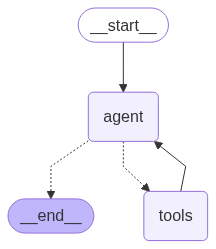

In [21]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [22]:
graph.invoke(
    input={"messages": [HumanMessage(content="How will the weather be tommorrow?")]}
)

{'messages': [HumanMessage(content='How will the weather be tommorrow?', additional_kwargs={}, response_metadata={}, id='5eeb140b-0e3a-4a4e-845d-ad2c775bc630'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dceraj2a9', 'function': {'arguments': '{}', 'name': 'off_topic'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 365, 'total_tokens': 375, 'completion_time': 0.022265353, 'prompt_time': 0.021808955, 'queue_time': 0.051268939, 'total_time': 0.044074308}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cf0d33c3-d9e3-4e7d-97d4-7c59c99b561d-0', tool_calls=[{'name': 'off_topic', 'args': {}, 'id': 'dceraj2a9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 365, 'output_tokens': 10, 'total_tokens': 375}),
  ToolMessage(content='Forbidden - do not respond to the user', name='off_topic', id='ab68ae30-2b87-4b76-9d5f-df22e06fdb

In [25]:
graph.invoke(input={
    "messages": [HumanMessage(content="Who is the owner and what are the timings of gym?")]
})

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT